In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
my_list = os.listdir('PlantVillage')

**Filter out corrupted images**

We have to run this code only one time, not run this code again and agin because it shows error.
Because this code delete corrupted images from the dataset permanently.

In [4]:
num_skipped = 0
for folder_name in my_list:
    folder_path = os.path.join("PlantVillage", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 2 images


In [3]:
image_size = 200
batch_size = 32

In [4]:
#tf.dataset help to read images in batches show our computer use large dataset in local.

In [5]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle = True,
    image_size = (image_size,image_size),
    batch_size = batch_size
)

Found 4626 files belonging to 5 classes.


In [6]:
#our floder names are our class names 
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [7]:
len(dataset)
#645*32 
#645 are number of batches

145

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) #batch 1
    print(label_batch.numpy()) #convert tensor to numpy

(32, 200, 200, 3)
[3 0 2 3 1 0 3 0 1 1 1 3 1 2 1 0 0 1 1 2 1 4 0 0 0 1 3 1 3 1 2 2]


In [9]:
# number of images in each floder
for dir,subdir,files in os.walk('PlantVillage'):
    print (dir,' ,', str(len(files)))

PlantVillage  , 0
PlantVillage\Pepper__bell___Bacterial_spot  , 997
PlantVillage\Pepper__bell___healthy  , 1477
PlantVillage\Potato___Early_blight  , 1000
PlantVillage\Potato___healthy  , 152
PlantVillage\Potato___Late_blight  , 1000


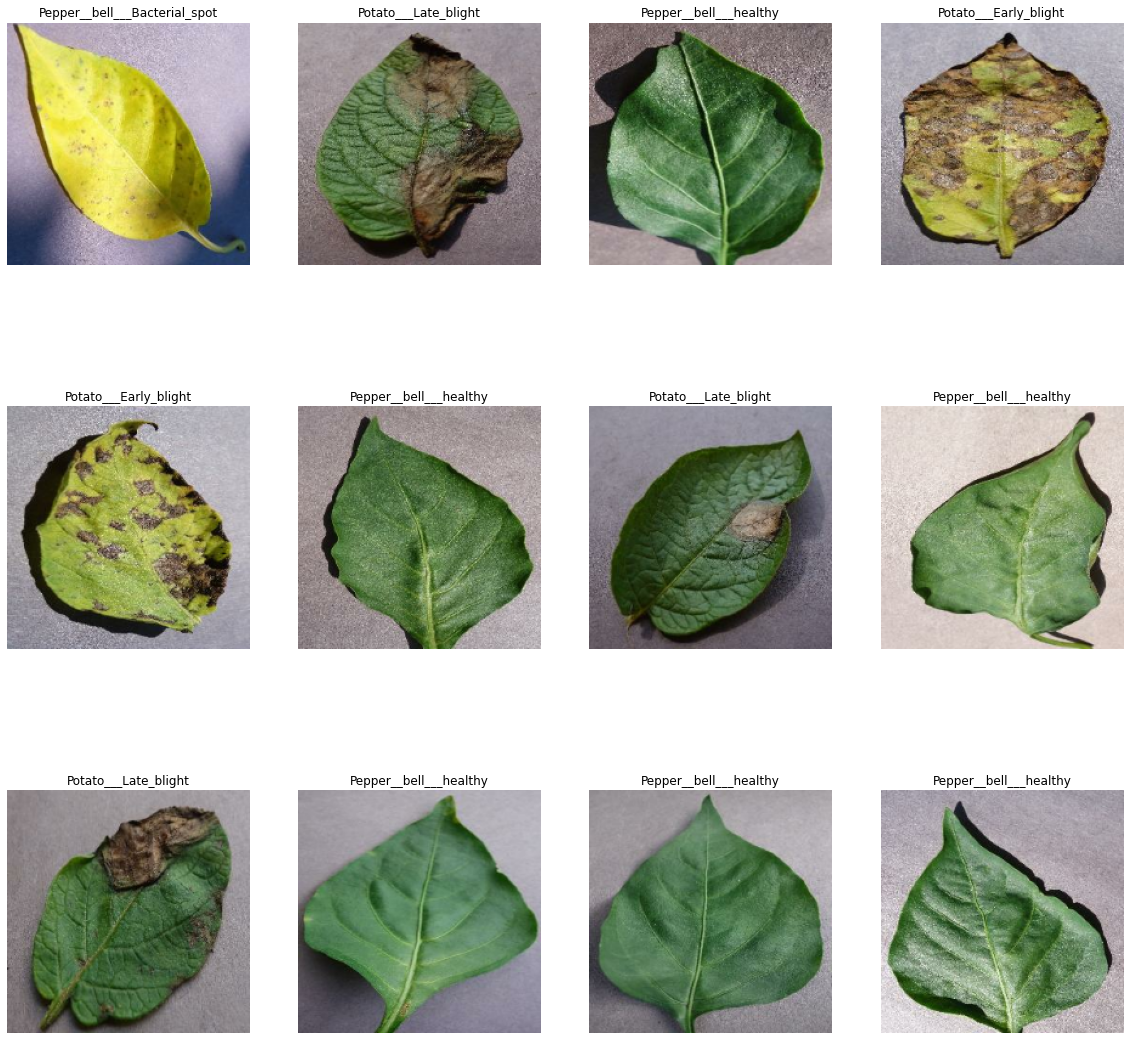

In [10]:
# visualize
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(4):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
    

# Split dataset

In [11]:
#we need 
#80% == training
#10% == validation
#10% == testing
len(dataset)

145

In [12]:
train_size = 0.8
len(dataset)*train_size

116.0

In [13]:
train_ds = dataset.take(116)
len(train_ds)

116

In [14]:
remain_ds = dataset.skip(116) #skip first 516 and take remaining
len(remain_ds)

29

In [15]:
val_size = 0.1
len(dataset)*val_size

14.5

In [16]:
val_ds = remain_ds.take(14)
len(val_ds)

14

In [17]:
test_ds = remain_ds.skip(14)
len(test_ds)

15

As we find the correct values of our split let's build a function that can split train, test and validation.

In [18]:
# split function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
# same as above

116
14
15


# Cache, Shuffle and Prefetch the dataset

Cache: Is the process by which  our model did't working on the preprocessing  process again and again , it's like it read the files, map the files and then train on it , but on second epochs it did't need to follow the same process it can go to train on the model because it already stored the previous steps.


Prefetch : Is the process in which we can use CPU to read batch 2 but at the same time our GPU train on batch 1 it can save time.
with the help to Prefetch we can go CPU and GPU for train our model at the same time.

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

***Creating a layer for Resizing and Normalization***

Before we feed our images to network, we should be resizing it to the desired size. Moreover,to imaprove model performance, we should normalize the image pixel value(keeping them in range 0 and 1 by dividing by 256). this should happen while training as well as inference.
Hence we can add that as a layer in our Sequential Model.

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./255)
])


# Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (batch_size, image_size, image_size, 3)
n_classes = 5

In [26]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 200, 200, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 198, 198, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 99, 99, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 97, 97, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 48, 48, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 46, 46, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
#checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose =1 , save_best_only = True,mode='max')
callbacks_list = [checkpoint]

In [30]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=callbacks_list,
)

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 1.4061 - accuracy: 0.3705
Epoch 1: val_accuracy improved from -inf to 0.47926, saving model to weights.best.hdf5
116/116 [==============================] - 66s 397ms/step - loss: 1.4061 - accuracy: 0.3705 - val_loss: 1.1493 - val_accuracy: 0.4793
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.5746
Epoch 2: val_accuracy improved from 0.47926 to 0.70737, saving model to weights.best.hdf5
116/116 [==============================] - 32s 276ms/step - loss: 1.0380 - accuracy: 0.5746 - val_loss: 0.7421 - val_accuracy: 0.7074
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.7207
Epoch 3: val_accuracy improved from 0.70737 to 0.73502, saving model to weights.best.hdf5
116/116 [==============================] - 33s 282ms/step - loss: 0.7199 - accuracy: 0.7207 - val_loss: 0.7594 - val_accuracy: 0.7350
Epoch 4/50
116/116 [=======================

116/116 [==============================] - 34s 290ms/step - loss: 0.0486 - accuracy: 0.9838 - val_loss: 0.0336 - val_accuracy: 0.9885
Epoch 29/50
116/116 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9873
Epoch 29: val_accuracy did not improve from 0.98848
116/116 [==============================] - 34s 295ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0596 - val_accuracy: 0.9770
Epoch 30/50
116/116 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9724
Epoch 30: val_accuracy did not improve from 0.98848
116/116 [==============================] - 34s 295ms/step - loss: 0.0800 - accuracy: 0.9724 - val_loss: 0.0418 - val_accuracy: 0.9793
Epoch 31/50
116/116 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9830
Epoch 31: val_accuracy did not improve from 0.98848
116/116 [==============================] - 35s 297ms/step - loss: 0.0488 - accuracy: 0.9830 - val_loss: 0.0226 - val_accuracy: 0.9885
Epoch 32/50
116/1

In [31]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 22s 38ms/step - loss: 0.0334 - accuracy: 0.9833


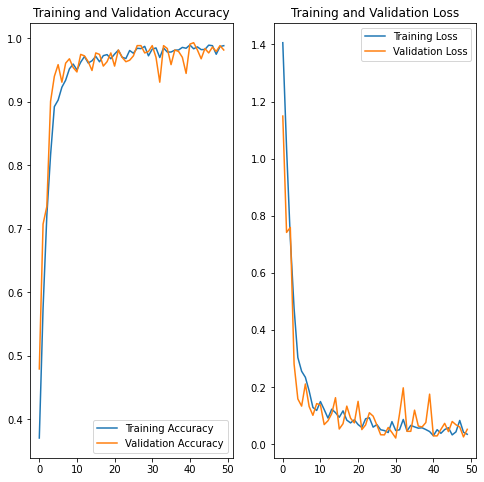

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
#save model architecture
model_json = model.to_json()
with open("basemodel.json", "w") as json_file:
    json_file.write(model_json)

In [34]:
#load model with the updated weights
from keras.models import model_from_json

json_file = open('basemodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights.best.hdf5")
print("Loaded model from disk")

Loaded model from disk


# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


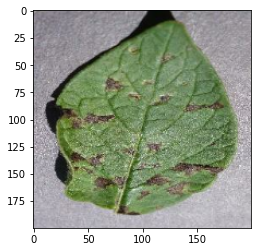

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = loaded_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


# Write a function for inference

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = loaded_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now run inference on few sample images

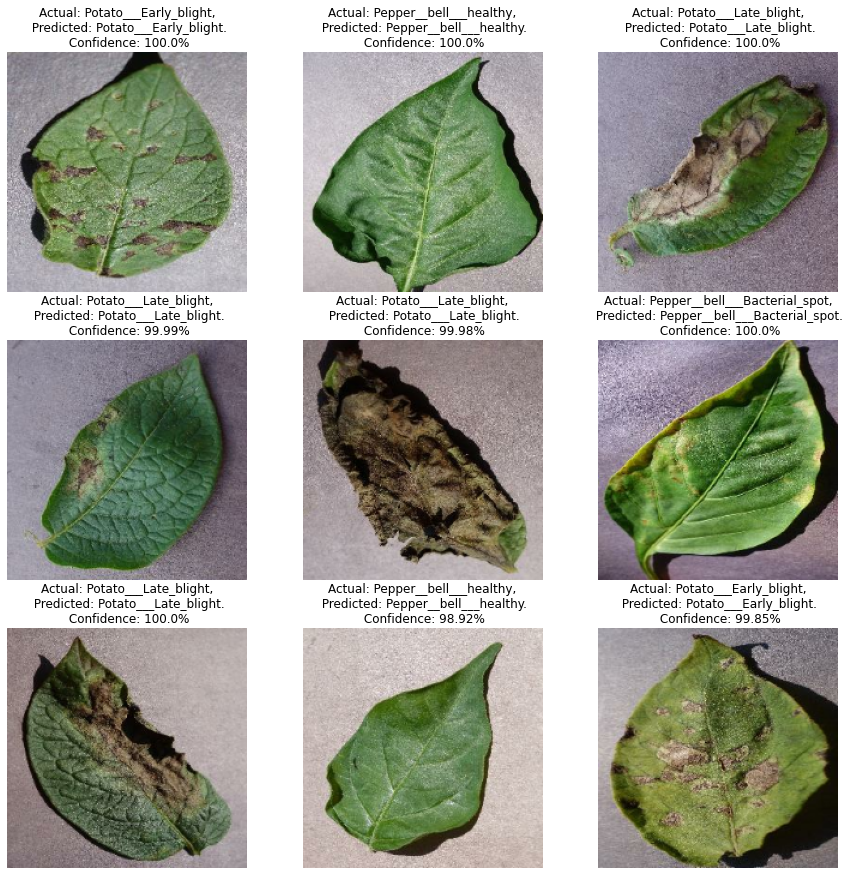

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9): #first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

We append the modelto the list of models as a new version

In [55]:
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
loaded_model.save(f"models/{model_version}")


INFO:tensorflow:Assets written to: models/1\assets


In [56]:
loaded_model.save("potatoes.h5")